In [2]:
# import necessary libraries 
import pyarrow
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
import os
from tensorflow import keras
from sklearn.metrics import (accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve, ConfusionMatrixDisplay, classification_report, auc, roc_curve, precision_recall_fscore_support, f1_score)
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses, regularizers, models
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_auc_score, roc_curve
import pickle



In [3]:
tf.keras.utils.set_random_seed(42)

# Paths

In [4]:
processed_dir = os.path.join( "..", "data", "processed")
final_dataset_path = os.path.join(processed_dir, 'FEData_For_Modelling.parquet')
minority_users_nn_pq = os.path.join(processed_dir, 'minority_users_nn.parquet')

models_dir = os.path.join( "..", "models","models")
model_dump_path = os.path.join(models_dir, 'nn_model.pkl')

Import Dataset

In [5]:
# Read the multi-part Parquet dataset
fds = dd.read_parquet(final_dataset_path)
fds['malicious'] = fds['malicious'].astype(int)
fds.head(4000)

,user,O,C,E,A,N,FCwke,FCowh,FCwh,SDwke,SDowh,SDwh,CDwke,CDowh,CDwh,JDwke,JDowh,JDwh,malicious
0,AAB1302,38,41,10,38,28,23,37,142,0,1,10,0,0,0,40,81,246,0
1,AAB1762,32,39,18,18,33,0,194,654,0,9,14,0,0,4,0,243,679,0
2,AAC0904,31,30,36,18,28,0,0,0,0,22,144,0,5,34,0,499,4025,0
3,AAC1033,42,40,40,22,29,0,0,0,0,14,72,0,0,1,0,1,2,0
4,AAC1489,24,13,42,24,38,0,0,0,0,1,175,0,0,2,0,101,5058,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,ZRF1980,43,41,26,16,30,0,9,1272,0,16,298,0,0,11,0,28,494,0
1996,ZUR1449,31,42,12,36,17,0,0,0,0,1,7,0,65,296,0,293,1322,0
1997,ZVW1475,38,35,18,24,37,0,0,0,0,0,1,0,0,0,0,2,7,0
1998,ZWS0755,45,47,42,39,28,0,0,0,0,58,266,0,0,0,0,148,810,0


In [6]:
X = fds.drop(columns = ['malicious']).compute()
y = fds['malicious'].compute()

In [7]:
# Split the fds into training and testing sets
X_train_w_name, X_test_w_name, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test = X_train_w_name.drop(columns=["user",]), X_test_w_name.drop(columns=["user",])

print("Train Labels before Resampling")
print(Counter(y_train))

Train Labels before Resampling
Counter({0: 1574, 1: 26})


In [8]:
'''#transform the dataset
oversample = SMOTE(sampling_strategy=0.4, random_state=42) #sampling_strategy=0.8
X_train, y_train = oversample.fit_resample(X_train, y_train)

print("Train Labels after Resampling")
print(Counter(y_train))'''

'#transform the dataset\noversample = SMOTE(sampling_strategy=0.4, random_state=42) #sampling_strategy=0.8\nX_train, y_train = oversample.fit_resample(X_train, y_train)\n\nprint("Train Labels after Resampling")\nprint(Counter(y_train))'

In [9]:
# Standardize features, using minmax and not standardscale -> got dif??
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
print(X_test.shape,X_train.shape)

(400, 17) (1600, 17)


## Building the model

In [10]:
# Define the neural network architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(17,)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
optimizer = Adam(learning_rate = 0.01)
# Compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['recall'])


c:\Users\hydro\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
history = model.fit(X_train, y_train,
                    epochs = 50,
                    batch_size = 64,
                    validation_split = 0.2,
                    shuffle = True,
                    #callbacks = [early_stopping]
                    )

# Evaluate the model
loss, accuracy = model.evaluate(X_train, y_train)
print("Final Loss:", loss)
print("Final Accuracy:", accuracy)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3235 - recall: 0.0000e+00 - val_loss: 0.1492 - val_recall: 0.0000e+00
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0888 - recall: 0.0000e+00 - val_loss: 0.1091 - val_recall: 0.0000e+00
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0801 - recall: 0.0000e+00 - val_loss: 0.1078 - val_recall: 0.0000e+00
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0760 - recall: 0.0000e+00 - val_loss: 0.1035 - val_recall: 0.0000e+00
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0761 - recall: 0.0000e+00 - val_loss: 0.1017 - val_recall: 0.0000e+00
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0743 - recall: 0.0000e+00 - val_loss: 0.1004 - val_recall: 0.0000e+00
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0718 - recall: 0.0000e+00 - val_loss: 0.0985 - val_recall: 0.0000e+00
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0717 - recall: 0.0000e+00 - v

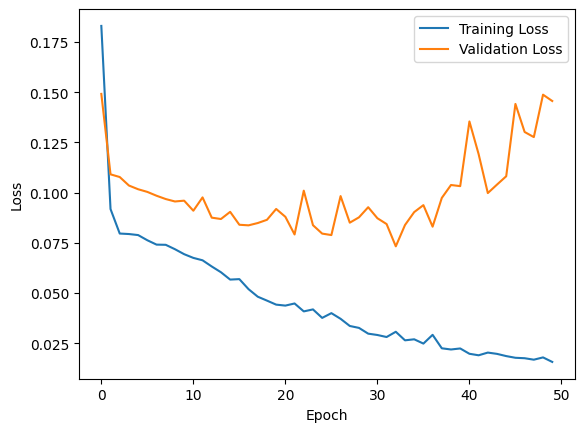

In [12]:
# loss plot
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

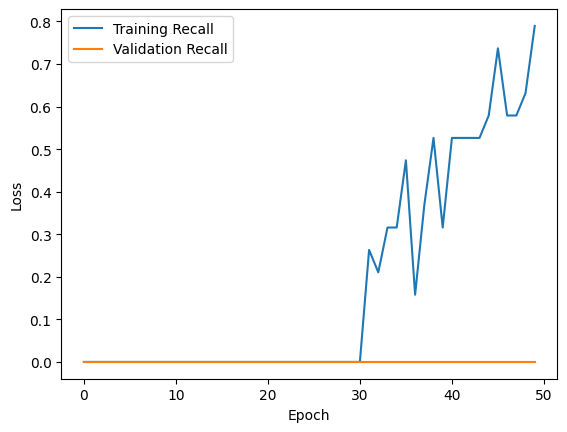

In [13]:
# acc plot
plt.plot(history.history["recall"], label="Training Recall")
plt.plot(history.history["val_recall"], label="Validation Recall")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Prediction

In [14]:
threshold = 0.5
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > threshold).astype(int)
set(list(y_pred.flatten()))

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


{0, 1}

Accuracy = 98.75%
Precision = 0.0
Recall = 0.0
f-1 score = 0.0

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       396
           1       0.00      0.00      0.00         4

    accuracy                           0.99       400
   macro avg       0.49      0.50      0.50       400
weighted avg       0.98      0.99      0.98       400



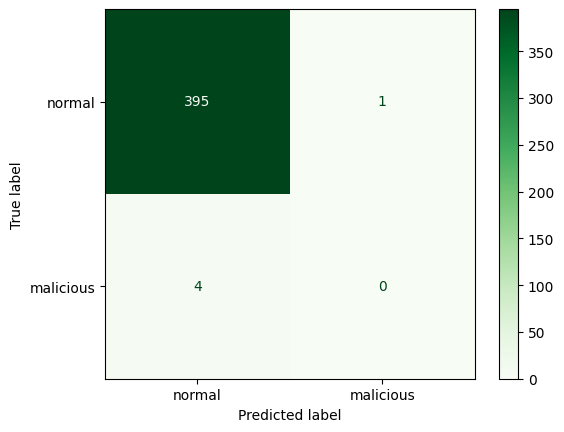

In [15]:
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['normal', 'malicious'])

print("Accuracy = {:.2f}%".format(accuracy_score(y_test, y_pred)*100))
print("Precision = {}".format(precision_score(y_test, y_pred)))
print("Recall = {}".format(recall_score(y_test, y_pred)))
print("f-1 score = {}".format(f1_score(y_test, y_pred)))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
disp.plot(cmap=plt.cm.Greens)
plt.show()

AUC score: 0.49873737373737376


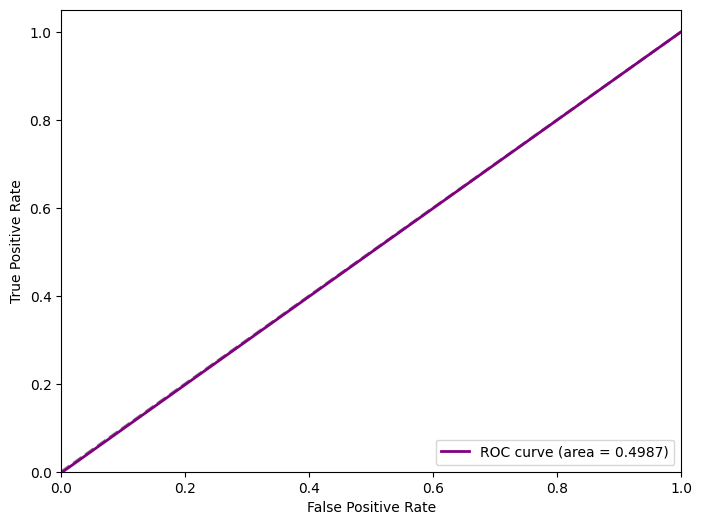

In [16]:
# ROC - AUC
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    plt.figure(figsize=(8, 6))
    #y_prob = best_dt.predict_proba(X_test_scaled)[::,1]
    dt_fpr, dt_tpr, thresholds = roc_curve(true_y, y_prob)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    roc_auc = auc(dt_fpr, dt_tpr)
    plt.plot(dt_fpr, dt_tpr, color='purple', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.legend(loc="lower right")

    # plt.legend()

plot_roc_curve(y_test, y_pred)
print(f'AUC score: {roc_auc_score(y_test, y_pred)}')

### Risk scores

In [17]:
def get_risk_score(X,threshold):    
    prob = model.predict(X)
    data = abs(threshold - prob)
    scaler = MinMaxScaler()
    confidence = scaler.fit_transform(data)
    return confidence

In [18]:
train_risk = get_risk_score(X_train,threshold)
test_risk = get_risk_score(X_test,threshold)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step


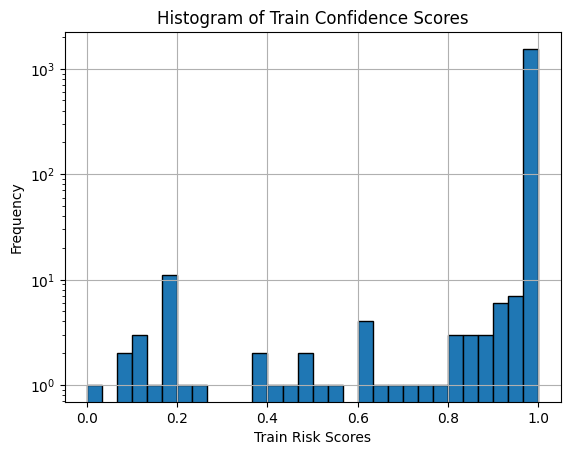

In [19]:
# Plot histogram for train risk score
plt.yscale('log')
plt.hist(train_risk, bins=30, edgecolor='black')  # Adjust bins as needed
plt.xlabel('Train Risk Scores')
plt.ylabel('Frequency')
plt.title('Histogram of Train Confidence Scores')
plt.grid(True)
plt.show()

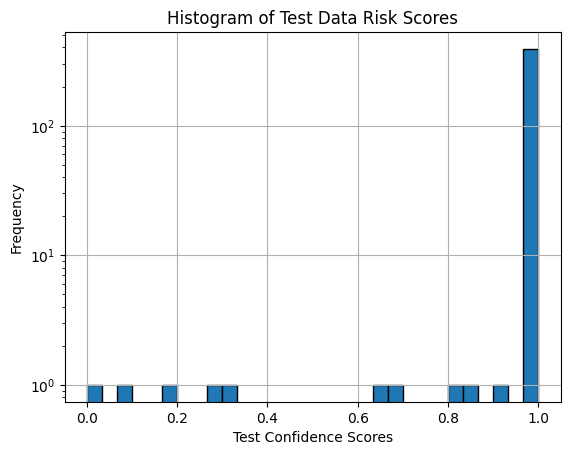

In [20]:
# Plot histogram for test risk score
plt.yscale('log')
plt.hist(test_risk, bins=30, edgecolor='black')  # Adjust bins as needed
plt.xlabel('Test Confidence Scores')
plt.ylabel('Frequency')
plt.title('Histogram of Test Data Risk Scores')
plt.grid(True)
plt.show()


In [21]:
print("Example Train Risk Scores:")
print(train_risk[:10])  
print("\nExample Test Risk Scores:")
print(test_risk[:10])

Example Train Risk Scores:
[[0.99996406]
 [1.        ]
 [0.99999803]
 [1.        ]
 [1.        ]
 [0.9999346 ]
 [0.99999994]
 [0.9999934 ]
 [0.99896604]
 [1.        ]]

Example Test Risk Scores:
[[0.9999999]
 [1.       ]
 [0.9999999]
 [0.9997146]
 [0.8035929]
 [0.9999628]
 [1.       ]
 [0.9999777]
 [1.       ]
 [0.9999999]]


# Export Model

In [22]:
pickle.dump(model.weights, open(model_dump_path,'wb'))

#  Our Prediction and the Confidence Associated with it

## Helper Functions

In [23]:
def df_toparquet(pdf,path):
    ddf = dd.from_pandas(pdf)
    # Export the DataFrame to a parquet file=
    ddf.to_parquet(path, engine='pyarrow')


In [24]:
def get_minority_tables(y_pred_value, y_test_value,df):
    # Get rows of minority data
    minority_data = df[(df['Actual'] == y_test_value) & (df['Prediction'] == y_pred_value)]
    display(minority_data)

Creating Table for export

In [25]:
names_array = list(X_test_w_name['user'])
final_guess = {'User': names_array, 'Actual': list(y_test.astype(bool)), 'Prediction': list(y_pred.flatten().astype(bool)), 'Confidence of Prediction': list(test_risk.flatten())}
refactored_df = pd.DataFrame(final_guess)
df_toparquet(refactored_df,minority_users_nn_pq)
refactored_df


,User,Actual,Prediction,Confidence of Prediction
0,VAH1292,False,False,1.000000
1,CJL0143,False,False,1.000000
2,MMB1967,False,False,1.000000
3,IVS1411,False,False,0.999715
4,MEB1743,False,False,0.803593
...,...,...,...,...
395,JIG1593,False,False,0.999982
396,MDL0294,False,False,0.999996
397,SSG0726,False,False,1.000000
398,BWJ1539,False,False,1.000000


In [26]:
print("False Positives")
get_minority_tables(1, 0,refactored_df)

print("False Negatives")
get_minority_tables(0, 1,refactored_df)

print("True Positives")
get_minority_tables(1,1,refactored_df)

False Positives


,User,Actual,Prediction,Confidence of Prediction
272,DLB0401,False,True,0.0


False Negatives


,User,Actual,Prediction,Confidence of Prediction
60,OKM1092,True,False,0.992119
224,TNB1616,True,False,0.996999
290,MCP0611,True,False,0.861983
318,TMT0851,True,False,1.000000


True Positives


,User,Actual,Prediction,Confidence of Prediction
